# Tweet Sentiment Analysis using Sentiment140 dataset

In this notebook, we built a tweet sentiment analysis. We used the **Sentiment140 dataset with 1.6 million tweets** dataset which you can download it on Kaggle from [here](https://www.kaggle.com/datasets/kazanova/sentiment140/code?resource=download).

## Import libraries
First, we start by importing the libraries. 

In [16]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import time
import os
import kaggle

import re
import string
import contractions
from autocorrect import Speller
import nltk

import sklearn 

## Download the dataset
We will download the dataset from the following [link](https://www.kaggle.com/datasets/kazanova/sentiment140/code?resource=download) if it is not already downloaded.

In [21]:
DATASET_PATH = './data/dataset.csv'

if not os.path.exists(DATASET_PATH):
    print("Downloading Dataset from Kaggle...")
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('kazanova/sentiment140/download', path='./data/', unzip=True)
    os.rename('./data/training.1600000.processed.noemoticon.csv', './data/dataset.csv')

## Dataset exploration

### Load dataset

Let's read the data from the CSV file. We use the `pandas` library to read the CSV file.

In [23]:
dataset = pd.read_csv(DATASET_PATH,header=None, encoding='latin-1')
dataset.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


As we can see on the first 4 lines of the dataset, we have 6 columns. In order, they are:

1. sentiment (0 for negative and 4 for positive)
2. id (unique number)
3. date of the tweet
4. query 
5. tweet author username
6. text content of the tweet

We will use the 1st column (the sentiment) as the label for our model, and the 6th column (the text content of the tweet) as the input. The other columns are not useful for our model. We will drop them.

In [24]:
dataset.columns = ['sentiment', 'id', 'date', 'query', 'user_name', 'tweet'] # rename columns
dataset = dataset.drop(['id', 'date', 'query', 'user_name'], axis=1) # drop unnecessary columns
dataset.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Explore dataset

Let's explore the dataset. We will check the number of tweets for each sentiment.

To do so, we will group the dataset by the sentiment, and count the number of tweets for each sentiment.

In [25]:
label_to_sentiment = {0:"Negative", 4:"Positive"}

dataset['sentiment'] = dataset['sentiment'].replace(label_to_sentiment) # replace labels with actual sentiment
distribution = dataset['sentiment'].value_counts()

We can now display the number of tweets for each sentiment. As we can see the dataset is well balanced. We have 800,000 tweets for each sentiment.

Text(0.5, 1.0, 'Sentiment distribution')

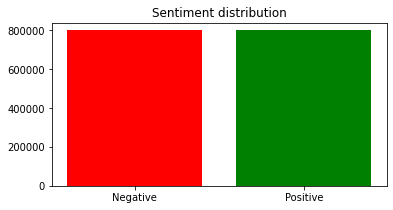

In [26]:
plt.figure(figsize=(6, 3))
plt.bar(distribution.index, distribution.values, color=['red', 'green'])
plt.title('Sentiment distribution')

## Data preprocessing

We will now clean the data. We based ourselves on this [tutorial](https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/) using `NLTK` library. 

### Text cleaning

First of all, we clean the text by lowercasing, removing the links, extra whitespace and punctuations. We also replace common contractions by full words.

In [28]:
from nltk.tokenize import regexp

def text_preprocessing(text):
     # lowercase
    text = text.lower()
    # remove extra whitespaces
    text = " ".join(text.split())
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove identifiers (e.g. @user)
    text = re.sub(r'@\S+', '', text)
    # replace common contractions by full words
    text = contractions.fix(text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove small words
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # spell correction (takes too much time, and doesn't improve that much accuracy)
    # text = Speller(lang='en', fast=True)(text)
    
    return text

Apply the cleaning function to the dataset.

In [29]:
dataset['tweet'] = dataset['tweet'].apply(text_preprocessing)
dataset.head()

,sentiment,tweet
0,Negative,awww that bummer you shoulda got david ca...
1,Negative,upset that cannot update his facebook texti...
2,Negative,dived many times for the ball managed save ...
3,Negative,whole body feels itchy and like its fire
4,Negative,not behaving all mad why here because...


### Tokenization
Here we will do several steps to tokenize the text. We will:

1. **Tokenize** the text using the `word_tokenize` function from `NLTK` library. This will split the text into words called tokens. 
2. Remove the **stopwords** using the `stopwords` function from `NLTK` library. Stopwords are trivial words like “I”, “the”, “you”, etc. that appear so frequently in the text that they may distort many NLP operations without adding much valuable information.
3. Remove words with **low frequency** and very **high frequency**. We are going to filter out words that do not appear enough in our dataset and those who appear too much. For that, we are going to set the low and high threshold. All words outside of this threshold will be filtered out.
4. **Stem** the words using the `PorterStemmer` function from `NLTK` library. Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. For example, the words “fishing”, “fished”, and “fisher” all have the stem “fish”.

We used stemming instead of lemmatization because in our case, we want to keep the words as short as possible. Lemmatization is a more complex process that takes into account the context of the word. We often use lemmatization when it comes to chatbots or question answering systems, where the context is important.

#### Setup for tokenization, stopwords and stemming

In [30]:
# word tokenizing
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
# get stopwords (words that don't add much meaning to a sentence)
nltk.download('stopwords') 
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
# get word frequency in the dataset
word_occurrences = {} # dictionary to store word occurrences
for tweet in dataset['tweet']:
    words = tweet.split()
    for word in words:
        if word in word_occurrences:
            word_occurrences[word] += 1
        else:
            word_occurrences[word] = 1
            
MIN_WORD_OCCURRENCE = 20 # same as in the chatbot course
TOP_FREQ_WORDS = 10 # defined by exploring the dataset
most_common_words = sorted(word_occurrences, key=word_occurrences.get, reverse=True)[:TOP_FREQ_WORDS]

In [33]:
# get stem of words (e.g. 'running' -> 'run')
nltk.download('wordnet')
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...


#### Tokenization, stopwords and stemming

In [34]:
# get number of words inside the dataset before tokenizing
all_words_before_tokenization = {}
for tweet in dataset['tweet']:
    for word in tweet.split():
        if word in all_words_before_tokenization:
            all_words_before_tokenization[word] += 1
        else:
            all_words_before_tokenization[word] = 1
number_words_before_tokenization = len(all_words_before_tokenization)

In [35]:
def tokenize(text):
    # 1. tokenize
    raw_tokens = nltk.word_tokenize(text)
    parsed_tokens = []
    
    for token in raw_tokens:
        # 2. remove stopwords
        if token not in stopwords:
            # 3. remove words with low frequency and very high frequency
            if token in word_occurrences and word_occurrences[token] > MIN_WORD_OCCURRENCE and word_occurrences[token] not in most_common_words:
                # # 4. stemming
                parsed_tokens.append(stemmer.stem(token))
                
    
    return parsed_tokens

Apply the tokenization function to the dataset.

In [36]:
dataset['tweet'] = dataset['tweet'].apply(tokenize)
dataset.head()

,sentiment,tweet
0,Negative,"[awww, bummer, shoulda, got, david, carr, thir..."
1,Negative,"[upset, updat, facebook, text, might, cri, res..."
2,Negative,"[mani, time, ball, manag, save, rest]"
3,Negative,"[whole, bodi, feel, itchi, like, fire]"
4,Negative,"[behav, mad, see]"


In [37]:
all_words_after_tokenization = {}
for tweet in dataset['tweet']:
    for word in tweet:
        if word in all_words_after_tokenization:
            all_words_after_tokenization[word] += 1
        else: 
            all_words_after_tokenization[word] = 1
number_words_after_tokenization = len(all_words_after_tokenization)

### Compare number of words before and after tokenization

As we can see, we went from 416 891 words to only 15 045. This is a huge reduction in the number of words. This will help us to train our model faster.

In [39]:
print("Number of words in the dataset before tokenization: ", number_words_before_tokenization)
print("Number of words in the dataset after tokenization: ", number_words_after_tokenization)

Number of words in the dataset before tokenization:  416891
Number of words in the dataset after tokenization:  15045


### Data visualization
Let's visualize the data. We will use the `wordcloud` library to display the most frequent words from positive and negative tweets.

In [40]:
def visualize_wordcloud(sentiment):
    words = []
    for tweet in dataset[dataset['sentiment'] == sentiment]['tweet']:
        words += tweet
    
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=500, random_state=21, max_font_size=110).generate(" ".join(words))
    plt.figure(figsize=(10, 7))
    plt.title(f"Most common words in {sentiment} tweets")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

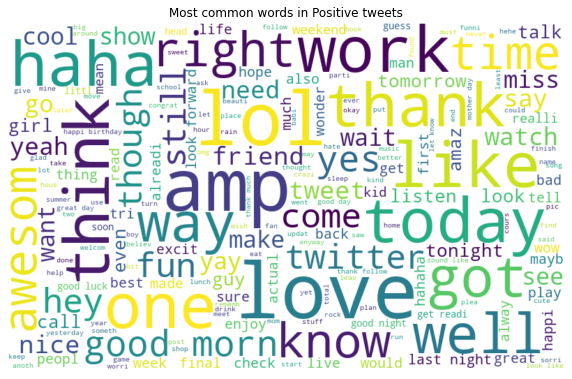

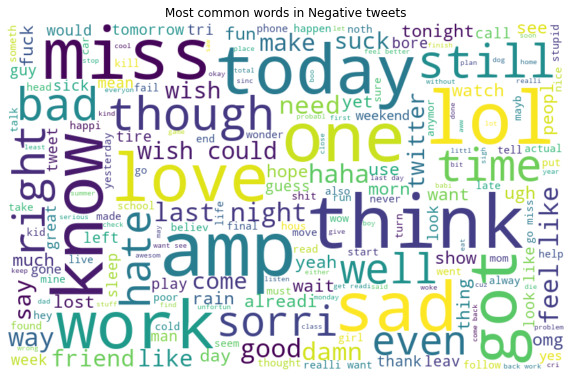

In [41]:
visualize_wordcloud(label_to_sentiment[4]) # positive tweets
visualize_wordcloud(label_to_sentiment[0]) # negative tweets